In [ ]:
import os
import sys
sys.path.append(os.path.join(os.path.dirname("__file__"), '..'))

from antra.antra import *
import json

In [ ]:
def get_start_x_counter():
    def f(examples):
        result = []
        for example in examples:
            row =  int(example["situation"]["target_object"]["position"]["row"]) - int(example["situation"]["agent_position"]["row"])
            result.append(row)
        return result
    return f

def get_start_y_counter():
    def f(examples):
        result = []
        for example in examples:
            col = int(example["situation"]["target_object"]["position"]["column"]) - int(example["situation"]["agent_position"]["column"])
            result.append(col)
        return result
    return f

def get_start_o_counter():
    def f(examples):
        result = []
        for example in examples:
            result.append("DOWN")
        return result
    return f

def update_x():
    def f(xs,az,os):
        results = []
        for x,a,o in zip(xs,az,os):
            if o =="RIGHT" and a == "walk":
                results.append(x + 1)
            elif o =="LEFT" and a == "walk":
                results.append(x - 1)
            else:
                results.append(x)
        return results
    return f

def update_y():
    def f(ys,az,os):
        results = []
        for y,a,o in zip(ys,az,os):
            if o =="UP" and a == "walk":
                results.append(y + 1)
            elif o =="DOWN" and a == "walk":
                results.append(y - 1)
            else:
                results.append(y)
        return results
    return f

def update_o():
    def f(az,os):
        results = []
        for a,o in zip(az,os):
            rotate_left = {"RIGHT":"UP", "LEFT":"DOWN", "UP":"LEFT","DOWN":"RIGHT"}
            rotate_right = {"UP":"RIGHT", "DOWN":"LEFT", "LEFT":"UP","RIGHT":"DOWN"}
            if a == "walk" or a == "NULL":
                results.append(o)
            elif a == "turn left":
                results.append(rotate_left[o])
            elif a == "turn right":
                results.append(rotate_right[o])
        return results
    return f

def update_a():
    def f(xs, ys, os):
        results = []
        for x, y, o in zip(xs,ys,os):
            if y == 0 and x ==0:
                results.append("NULL")
                continue
            if y == 0:
                if x > 0:
                    if o == "LEFT":
                        results.append("walk")
                    elif o in ["RIGHT", "UP"]:
                        results.append("turn left")
                    elif o == "DOWN":
                        results.append("turn right")
                if x < 0:
                    if o == "RIGHT":
                        results.append("walk")
                    elif o  == "UP":
                        results.append("turn right")
                    elif o in ["LEFT", "DOWN"]:
                        results.append("turn left")
            else:
                if y > 0:
                    if o == "DOWN":
                        results.append("walk")
                    elif o in ["UP", "LEFT"]:
                        results.append("turn left")
                    elif o == "RIGHT":
                        results.append("turn right")
                if y < 0:
                    if o == "UP":
                        results.append("walk")
                    elif o in ["DOWN", "RIGHT"]:
                        results.append("turn left")
                    elif o == "LEFT":
                        results.append("turn right")
        return results
    return f


def get_counter_compgraph():
    example = GraphNode.leaf(name=f"examples")
    fx = get_start_x_counter()
    fy = get_start_y_counter()
    fo = get_start_o_counter()
    fa = update_a()
    x_counter = GraphNode(example, name="x0", forward=fx)
    y_counter = GraphNode(example, name="y0", forward=fy)
    o_counter = GraphNode(example, name="o0", forward=fo)
    action = GraphNode(x_counter,y_counter,o_counter, name="a0", forward=fa)
    for i in range(1, 20):
        fx = update_x()
        fy = update_y()
        fa = update_a()
        fo = update_o()
        new_x_counter = GraphNode(x_counter, action, o_counter, name="x"+str(i), forward=fx)
        new_y_counter = GraphNode(y_counter,action,o_counter, name="y"+str(i), forward=fy)
        new_o_counter = GraphNode(action,o_counter, name="o"+str(i), forward=fo)
        new_action = GraphNode(new_x_counter, new_y_counter,new_o_counter, name="a"+str(i), forward=fa)
        x_counter = new_x_counter
        y_counter = new_y_counter
        o_counter = new_o_counter
        action = new_action
    return ComputationGraph(action)

In [ ]:
path_to_data = "../../../data-files/ReaSCAN-Simple/data-compositional-splits.txt"
data_json = json.load(open(path_to_data, "r"))

In [ ]:
NUM = 200
goods = []
for ex in data_json["examples"]["train"]:
    if ex["adverb_in_command"] == "":
        goods.append(ex)
        if len(goods) > NUM-1:
            break

In [ ]:
input = GraphInput({"examples":goods})
G = get_counter_compgraph()
_ = G.compute(input) # always return null?
for j in range(NUM):
    # print("\n\n\n", j, "a;oifwje;awfeoijawj \n\n\n")
    # print(goods[j]["command"])
    # print(goods[j]["target_commands"])
    for i in range(20):
        print(G.compute_node("x" + str(i), input)[j])
        print(G.compute_node("y" + str(i), input)[j])
        print(G.compute_node("o" + str(i), input)[j])
        print(G.compute_node("a" + str(i), input)[j])
        if len(goods[j]["target_commands"].split(",")) <= i and G.compute_node("a" + str(i), input)[j] != "NULL":
            print("\n\nOH NO")
            print(G.compute_node("a" + str(i), input)[j])
            print(goods[j]["target_commands"].split(",")[i])
            print(MEME)
        if len(goods[j]["target_commands"].split(",")) > i and G.compute_node("a" + str(i), input)[j] != goods[j]["target_commands"].split(",")[i]:
            print("\n\nOH NO")
            print(G.compute_node("a" + str(i), input)[j])
            print(goods[j]["target_commands"].split(",")[i])
            print(MEME)
    # print(G.compute_node("a" + str(i), input)[j] == "turn left")
    # print("\n")

Read-in ReaSCAN and Manipulate

In [12]:
import os
import sys
sys.path.append(os.path.join(os.path.dirname("__file__"), '..'))
from ReaSCAN_dataset import *

# Init of the vocab.
intransitive_verbs = ["walk"]
transitive_verbs = ["push", "pull"]
adverbs = ["while zigzagging", "while spinning", "cautiously", "hesitantly"]
nouns = ["circle", "cylinder", "square", "box"]
color_adjectives = ["red", "blue", "green", "yellow"]
size_adjectives = ["big", "small"]
relative_pronouns = ["that is"]
relation_clauses = ["in the same row as", 
                    "in the same column as", 
                    "in the same color as", 
                    "in the same shape as", 
                    "in the same size as",
                    "inside of"]
vocabulary = ReaSCANVocabulary.initialize(intransitive_verbs=intransitive_verbs,
                                   transitive_verbs=transitive_verbs, adverbs=adverbs, nouns=nouns,
                                   color_adjectives=color_adjectives,
                                   size_adjectives=size_adjectives, 
                                   relative_pronouns=relative_pronouns, 
                                   relation_clauses=relation_clauses)
min_object_size = 1
max_object_size = 4
object_vocabulary = ObjectVocabulary(shapes=vocabulary.get_semantic_shapes(),
                                     colors=vocabulary.get_semantic_colors(),
                                     min_size=min_object_size, max_size=max_object_size)

In [13]:
# Read-in info.
path_to_data = "../../../data-files/ReaSCAN-Simple/data-compositional-splits.txt"
ReaSCAN_data_json = json.load(open(path_to_data, "r"))

command: walk,to,the,big,red,circle,while,zigzagging


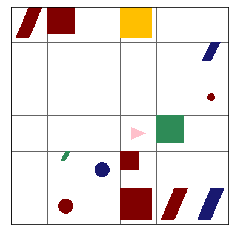

action: ['turn left', 'turn left', 'walk', 'walk', 'turn left', 'walk', 'walk']


In [27]:
example = ReaSCAN_data_json["examples"]["train"][random.randint(0, len(ReaSCAN_data_json["examples"]["train"])-1)]
command = example["command"]
print(f"command: {command}")
situation = example["situation"]
world = World(grid_size=6, colors=vocabulary.get_semantic_colors(),
              object_vocabulary=object_vocabulary,
              shapes=vocabulary.get_semantic_shapes(),
              save_directory="./tmp/")
world.clear_situation()
for obj_idx, obj in situation["placed_objects"].items():
    world.place_object(
        Object(size=int(obj["object"]["size"]), color=obj["object"]["color"], shape=obj["object"]["shape"]), 
        position=Position(row=int(obj["position"]["row"]), column=int(obj["position"]["column"]))
    )
world.place_agent_at(
    Position(
        row=int(situation["agent_position"]["row"]), 
        column=int(situation["agent_position"]["column"])
))
_ = world.render_simple()

# HERE: you can change to other target object.
target_position = Position(
    row=int(situation['target_object']['position']["row"]), 
    column=int(situation['target_object']['position']["column"])
)
world.go_to_position(position=target_position, manner='', primitive_command="walk")
target_commands, target_demonstration = world.get_current_observations()
print(f"action: {target_commands}")